<a href="https://colab.research.google.com/github/3-Ada/image_classification/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intel Image Classification

## Step 0: import dataset from Kaggle

The dataset "Intel Image Classification" is used for this project

Here is the link for it: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

To import the chosen dataset from Kaggle, we need to perform the following steps:

1. Import the library for working with files in Google Colab.

In [1]:
from google.colab import files # library for working with files

2. Next, we need upload the kaggle.json file from local machine to Google Colab. This file is used to authenticate access to the Kaggle platform and allows to interact with Kaggle's datasets.
3. After uploading the file, we need install Kaggle API client, which allows to interact with Kaggle within Colab.

In [2]:
files.upload() # upload kaggle.json from pc

!pip install -q kaggle # install kaggle API client

Saving kaggle.json to kaggle.json


4. The folder with name ".kaggle" is created in the root directory to store kaggle.json
5. kaggle.json is moved to the created folder.
6. Set the permissions of file to ensure its security.

In [3]:
! mkdir ~/.kaggle # create folder with name .kaggle
! cp kaggle.json ~/.kaggle/ # move kaggle.json to created directory
! chmod 600 /root/.kaggle/kaggle.json # change permissions to more secure

7. Download the dataset from Kaggle

In [4]:
! kaggle datasets download -d puneet6060/intel-image-classification

 97% 336M/346M [00:02<00:00, 161MB/s]
100% 346M/346M [00:02<00:00, 155MB/s]


8. The unzip command may produce a lengthy output. To keep the cell output clean, we can use the magic command %%capture, which suppresses the output of the cell.
9. For storing images, director "image_files" is created.
10. Unzip the "intel-image-classification.zip" file into the "/content/image_files/" directory

In [5]:
# for not showing output
%%capture
! mkdir /content/image_files
! unzip intel-image-classification.zip -d /content/image_files

## Step 1: explore the dataset

First, we need explore the dataset.

Let's import all the necessary libraries for this step.

In [6]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

Then let's create dataframe which contain information about each image, such as file name, label and category.

For doing this, we iterate over the items in the labels. After we traverse though folder with name of given label, and add information about each image to created dataframe.

In [15]:
root_dir = "/content/image_files/seg_train/seg_train/"
sub_folders = os.listdir(root_dir)
labels = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4,
          'street': 5}

data = []

for s, l in labels.items():
  for r, d, f in os.walk(root_dir + s):
      for file in f:
          if ".jpg" in file:
              data.append((os.path.join(s,file), l, s))

df_images_info = pd.DataFrame(data, columns=['file_name', 'label', 'category'])

In [8]:
df_images_info.head()

,file_name,label,category
0,buildings/11827.jpg,0,buildings
1,buildings/11959.jpg,0,buildings
2,buildings/808.jpg,0,buildings
3,buildings/2238.jpg,0,buildings
4,buildings/18438.jpg,0,buildings


Let's check how many images we have.

In [9]:
df_images_info.shape

(14034, 3)

The dataset contains 14 034 images.

Text(0.5, 1.0, 'Amount of images in each category')

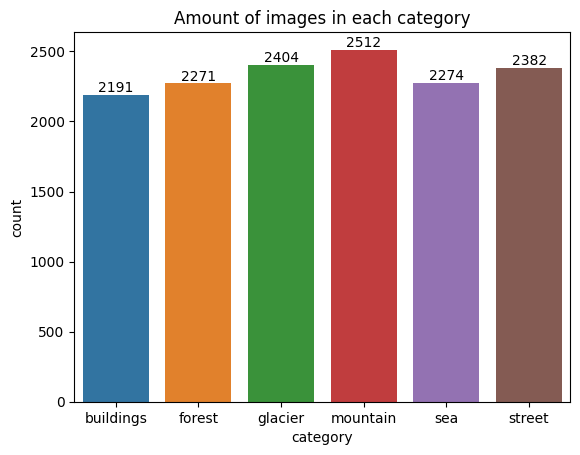

In [10]:
ax = sns.countplot(data=df_images_info, x='category')
ax.bar_label(ax.containers[0])
ax.set_title("Amount of images in each category")

As we can see, the dataset is pretty balanced.

To better understand the dataset, let's plot examples from each category.

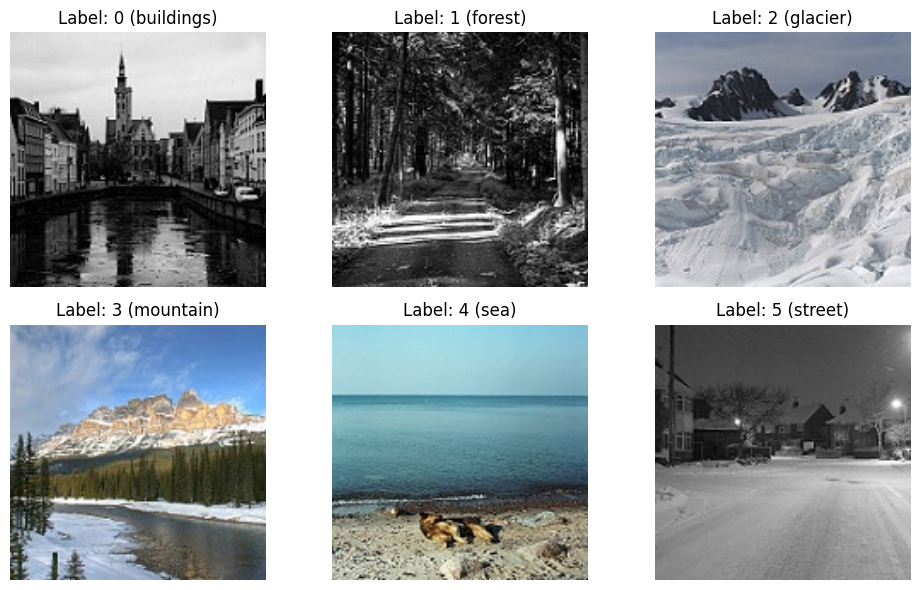

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

index = 0
for i in range(2):
    for j in range(3):

      label = df_images_info['label'][index]
      category = df_images_info['category'][index]
      file_path = os.path.join(root_dir, df_images_info.file_name[index])

      # read an image with OpenCV
      image = cv2.imread(file_path)

      # convert the image to RGB color space.
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # resize image
      image = cv2.resize(image, (256, 256))

      ax[i,j].imshow(image)
      ax[i,j].set_title(f"Label: {label} ({category})")
      ax[i,j].axis('off')
      # add to the index amount of images in category
      index += len(df_images_info[df_images_info['category'] == category])

plt.tight_layout()
plt.show()

## Step 2: prepare the model

Next, we set a baseline. As always, the first step is install and import of necessary libraries.

In [7]:
%%capture
!pip install timm

In [8]:
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm

from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

We define the "CustomDataset" class which is used to load and preprocess images from the provided dataset. "CustomDataset" inherits Dataset class from PyTorch.

In [9]:
class CustomDataset(Dataset):
    def __init__(self, df):

      self.root_dir = root_dir
      self.df = df
      self.file_names = df['file_name'].values
      self.labels = df['label'].values

      self.transform = A.Compose([A.Resize(image_size, image_size),
                                  ToTensorV2(),])

    def __len__(self):
      return len(self.df)

    def __getitem__(self, index): # Get sample from dataset

      label = self.labels[index]
      file_path = os.path.join(self.root_dir, self.file_names[index])

      # read an image with OpenCV
      image = cv2.imread(file_path)

      # convert the image to RGB color space.
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # apply transformation
      transformed = self.transform(image=image)
      image = transformed['image']

      # normalize because ToTensorV2() doesn't normalize the image
      image = image/255

      return image, label

Also we need define two other functions: for training one epoch and for validation one epoch.

In [10]:
def train_one_epoch(dataloader, model, optimizer, scheduler, criterion):
  # training mode
  model.train()

  final_y = []
  final_y_pred = []
  final_loss = []

  for step, batch in enumerate(dataloader):
      X = batch[0].to(device)
      y = batch[1].to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      with torch.set_grad_enabled(True):

          y_pred = model(X)

          loss = criterion(y_pred, y)

          # convert y and y_pred to lists
          y =  y.detach().to(device).cpu().numpy().tolist()
          y_pred =  y_pred.detach().to(device).cpu().numpy().tolist()

          final_y.extend(y)
          final_y_pred.extend(y_pred)
          final_loss.append(loss.item())

          # optimize
          loss.backward()
          optimizer.step()

      scheduler.step()

  # calculate statistics
  loss = np.mean(final_loss)
  final_y_pred = np.argmax(final_y_pred, axis=1)
  metric = accuracy_score(final_y, final_y_pred)

  return metric, loss

In [11]:
def validate_one_epoch(dataloader, model, criterion):
  # validation mode
  model.eval()

  final_y = []
  final_y_pred = []
  final_loss = []

  for step, batch in enumerate(dataloader):
      X = batch[0].to(device)
      y = batch[1].to(device)

      with torch.no_grad():
          y_pred = model(X)

          loss = criterion(y_pred, y)

          # convert y and y_pred to lists
          y =  y.detach().to(device).cpu().numpy().tolist()
          y_pred =  y_pred.detach().to(device).cpu().numpy().tolist()

          # extend original list
          final_y.extend(y)
          final_y_pred.extend(y_pred)
          final_loss.append(loss.item())

  # calculate statistics
  loss = np.mean(final_loss)
  final_y_pred = np.argmax(final_y_pred, axis=1)
  metric = accuracy_score(final_y, final_y_pred)

  return metric, loss

As we can see code for training and validation functions are similar. However, mixing them into a single function can make the code more complex and harder to understand. So it's better to keep them separate for better code organization and readability.

Now let's define function which fits the model for all epochs.

In [12]:
# fit model for all epochs
def fit(model, optimizer, scheduler, epochs, criterion,
        train_dataloader, valid_dataloader=None):
    acc_list = []
    loss_list = []
    val_acc_list = []
    val_loss_list = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        acc, loss = train_one_epoch(train_dataloader, model, optimizer,
                                    scheduler, criterion)

        print(f'Train Loss: {loss:.4f} Train Accuracy: {acc:.4f}')
        acc_list.append(acc)
        loss_list.append(loss)

        if valid_dataloader != None:
            val_acc, val_loss = validate_one_epoch(valid_dataloader, model,
                                                   criterion)
            print(f'Validation Loss: {val_loss:.4f} Validation Acc: {val_acc:.4f}')
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)

    return acc_list, loss_list, val_acc_list, val_loss_list, model

Also we need function for visualisation the results (loss and accuracy).

In [18]:
def visualize_history(acc, loss, val_acc, val_loss):
    fig, ax = plt.subplots(1,2, figsize=(12,4))

    list_for_plot = [acc, loss, val_acc, val_loss]

    for i in range(2):
      ax[i].plot(range(len(list_for_plot[i])), list_for_plot[i], label = 'train')
      ax[i].plot(range(len(list_for_plot[i+2])), list_for_plot[i+2], label = 'valid')
      ax[i].set_xticks(range(len(loss)), range(len(loss)))
      ax[i].set_xlabel('Epochs')
      ax[i].legend(loc="upper right")
    ax[0].set_title('Metric (Accuracy)')
    ax[1].set_title('Loss')
    plt.show()

Let's define settings of the training process.

In [19]:
image_size = 256
batch_size = 32

# if GPU is avalaible training will be conducted on it, if not use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_folds = 5

n_classes = len(df_images_info.label.unique())
backbone = 'resnet18'

learning_rate = 1e-4

epochs = 5
lr_min = 1e-5

We use the cross-validation strategy for splitting dataset.

In [20]:
# Create a new column for cross-validation folds
df_images_info["kfold"] = -1

# Initialize the kfold class
skf = StratifiedKFold(n_splits=n_folds)

# Fill the new column
for fold, (train_, val_) in enumerate(skf.split(X = df_images_info, y = df_images_info.label)):
      df_images_info.loc[val_ , "kfold"] = fold

Let's choose model and run it for each fold of the cross-validation.

We use library with name "timm" to get pre-trained models.
As model, we use a ResNet with 18 layers. ResNet (Residual Network) is a type of convolutional neural network (CNN) using residual blocks.
There are many different models in the ResNet family. We will explore them in the step 3 and select the most suitable architecture for the task.

To train the model, we also need a loss function (criterion), an optimization algorithm (optimizer) and, a learning rate scheduler.

As loss function we will use categorical cross-entropy, which suit well for multi-class classification.

As optimizer, we will use algorithm Adam. Adam is a commonly used optimization algorithm.

We will use cosine decay as a learning rate scheduler for fine-tuning.

Epoch 1/5
Train Loss: 0.7893 Train Accuracy: 0.7834
Validation Loss: 0.2957 Validation Acc: 0.9102
Epoch 2/5
Train Loss: 0.2822 Train Accuracy: 0.9094
Validation Loss: 0.2236 Validation Acc: 0.9266
Epoch 3/5
Train Loss: 0.2190 Train Accuracy: 0.9280
Validation Loss: 0.2087 Validation Acc: 0.9312
Epoch 4/5
Train Loss: 0.1949 Train Accuracy: 0.9373
Validation Loss: 0.2045 Validation Acc: 0.9277
Epoch 5/5
Train Loss: 0.1757 Train Accuracy: 0.9427
Validation Loss: 0.2039 Validation Acc: 0.9295


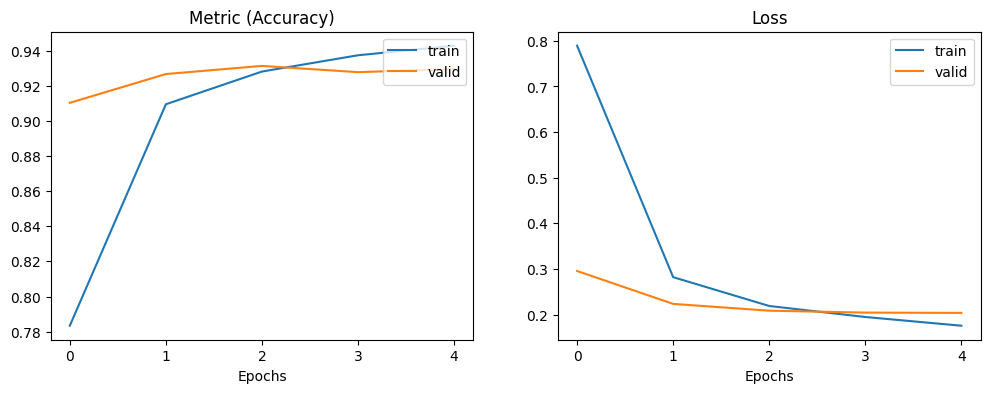

Epoch 1/5
Train Loss: 0.7969 Train Accuracy: 0.7717
Validation Loss: 0.2830 Validation Acc: 0.9081
Epoch 2/5
Train Loss: 0.2879 Train Accuracy: 0.9071
Validation Loss: 0.2135 Validation Acc: 0.9291
Epoch 3/5
Train Loss: 0.2305 Train Accuracy: 0.9233
Validation Loss: 0.1911 Validation Acc: 0.9362
Epoch 4/5
Train Loss: 0.1997 Train Accuracy: 0.9354
Validation Loss: 0.1885 Validation Acc: 0.9344
Epoch 5/5
Train Loss: 0.1793 Train Accuracy: 0.9408
Validation Loss: 0.1859 Validation Acc: 0.9341


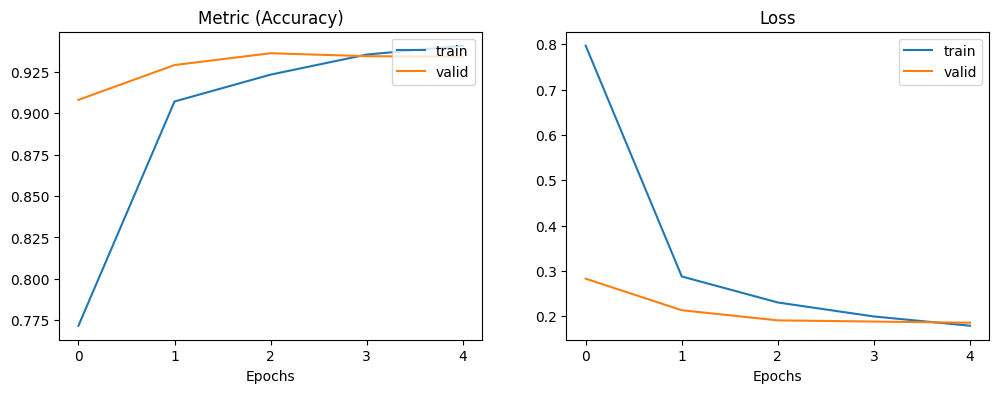

Epoch 1/5
Train Loss: 0.8095 Train Accuracy: 0.7882
Validation Loss: 0.2979 Validation Acc: 0.9081
Epoch 2/5
Train Loss: 0.2787 Train Accuracy: 0.9099
Validation Loss: 0.2269 Validation Acc: 0.9238
Epoch 3/5
Train Loss: 0.2216 Train Accuracy: 0.9270
Validation Loss: 0.2102 Validation Acc: 0.9284
Epoch 4/5
Train Loss: 0.1911 Train Accuracy: 0.9355
Validation Loss: 0.2024 Validation Acc: 0.9330
Epoch 5/5
Train Loss: 0.1823 Train Accuracy: 0.9406
Validation Loss: 0.2051 Validation Acc: 0.9280


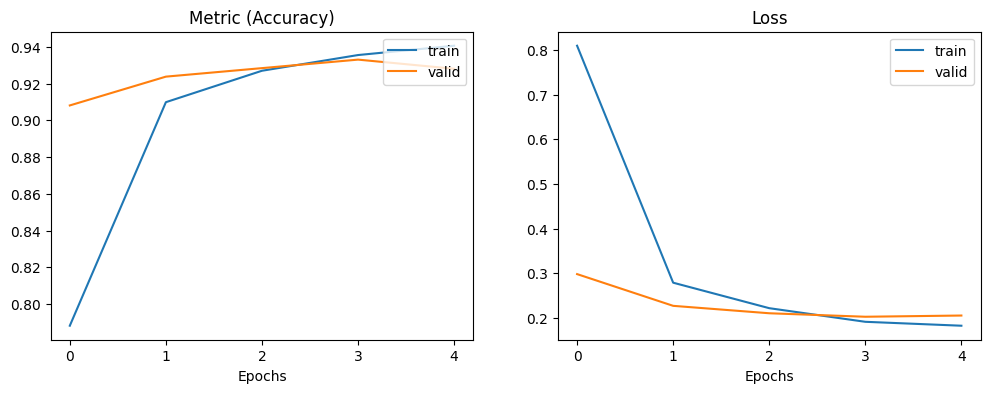

Epoch 1/5
Train Loss: 0.8067 Train Accuracy: 0.7751
Validation Loss: 0.2821 Validation Acc: 0.9152
Epoch 2/5
Train Loss: 0.2899 Train Accuracy: 0.9050
Validation Loss: 0.2215 Validation Acc: 0.9277
Epoch 3/5
Train Loss: 0.2238 Train Accuracy: 0.9275
Validation Loss: 0.2007 Validation Acc: 0.9312
Epoch 4/5
Train Loss: 0.2001 Train Accuracy: 0.9330
Validation Loss: 0.1953 Validation Acc: 0.9298
Epoch 5/5
Train Loss: 0.1833 Train Accuracy: 0.9386
Validation Loss: 0.1947 Validation Acc: 0.9316


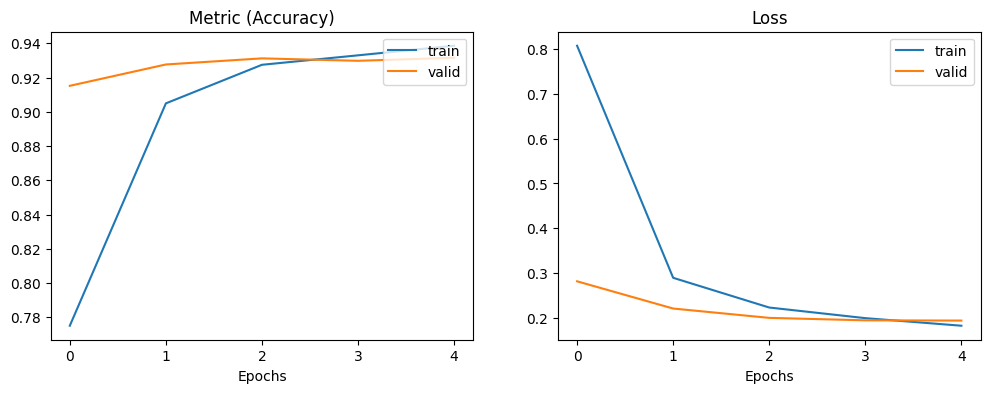

Epoch 1/5
Train Loss: 0.8390 Train Accuracy: 0.7664
Validation Loss: 0.3152 Validation Acc: 0.8999
Epoch 2/5
Train Loss: 0.2916 Train Accuracy: 0.9061
Validation Loss: 0.2438 Validation Acc: 0.9141
Epoch 3/5
Train Loss: 0.2255 Train Accuracy: 0.9252
Validation Loss: 0.2190 Validation Acc: 0.9223
Epoch 4/5
Train Loss: 0.1967 Train Accuracy: 0.9377
Validation Loss: 0.2123 Validation Acc: 0.9255
Epoch 5/5
Train Loss: 0.1813 Train Accuracy: 0.9401
Validation Loss: 0.2152 Validation Acc: 0.9259


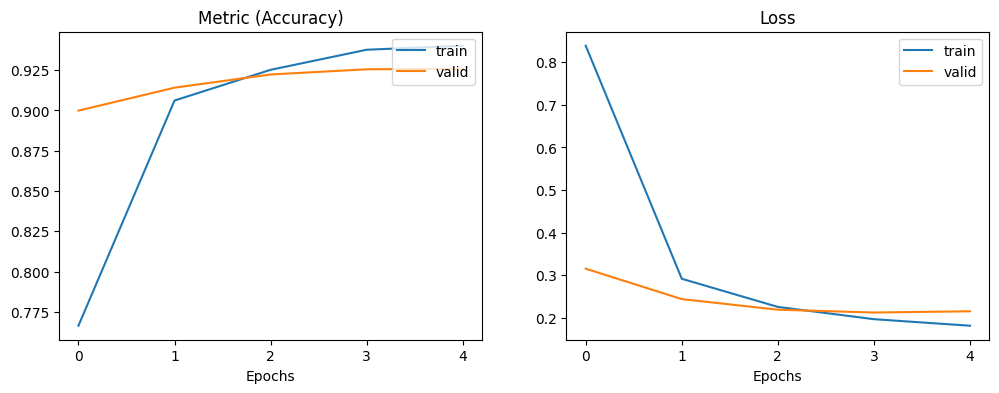

In [21]:
for fold in range(n_folds):
  train_df = df_images_info[df_images_info.kfold != fold].reset_index(drop=True)
  valid_df = df_images_info[df_images_info.kfold == fold].reset_index(drop=True)

  train_dataset = CustomDataset(train_df)
  valid_dataset = CustomDataset(valid_df)

  train_dataloader = DataLoader(train_dataset,
                      batch_size = batch_size,
                      shuffle = True)
  valid_dataloader = DataLoader(valid_dataset,
                      batch_size = batch_size,
                      shuffle = False)


  model = timm.create_model(backbone,
                      pretrained = True,
                      num_classes = n_classes)

  model = model.to(device)

  criterion = nn.CrossEntropyLoss()


  optimizer = torch.optim.Adam(model.parameters(),
                        lr = learning_rate,
                        weight_decay = 0,)

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                         T_max= np.ceil(len(train_dataloader.dataset) / batch_size) * epochs,
                                                         eta_min=lr_min)

  acc, loss, val_acc, val_loss, model = fit(model, optimizer, scheduler, epochs,
                                            criterion, train_dataloader, valid_dataloader)

  visualize_history(acc, loss, val_acc, val_loss)


## Step 3: run experiments

Now let's run some experiments, it would be interesting to  change the following parameters:

1. epochs: from 2 to 10
2. image size: from 128 to 1024
3. learning rate: from 0.0001 to 0.001
4. backbone: different models from the ResNet family

However before we need create a function for making this process easier.

In [22]:
# if GPU is avalaible training will be conducted on it, if not use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
def run_experiment(epochs, learning_rate, image_size, backbone, df_images_info):
  batch_size = 32

  n_folds = 3

  n_classes = len(df_images_info.label.unique())

  lr_min = 1e-5

  acc_list = []
  loss_list = []
  val_acc_list = []
  val_loss_list = []

  # Create a new column for cross-validation folds
  df_images_info["kfold"] = -1

  # Initialize the kfold class
  skf = StratifiedKFold(n_splits=n_folds)

  # Fill the new column
  for fold, (train_, val_) in enumerate(skf.split(X = df_images_info, y = df_images_info.label)):
        df_images_info.loc[val_ , "kfold"] = fold

  for fold in range(n_folds):
    train_df = df_images_info[df_images_info.kfold != fold].reset_index(drop=True)
    valid_df = df_images_info[df_images_info.kfold == fold].reset_index(drop=True)

    train_dataset = CustomDataset(train_df)
    valid_dataset = CustomDataset(valid_df)

    train_dataloader = DataLoader(train_dataset,
                        batch_size = batch_size,
                        shuffle = True)
    valid_dataloader = DataLoader(valid_dataset,
                        batch_size = batch_size,
                        shuffle = False)


    model = timm.create_model(backbone,
                        pretrained = True,
                        num_classes = n_classes)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()


    optimizer = torch.optim.Adam(model.parameters(),
                          lr = learning_rate,
                          weight_decay = 0,)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                          T_max= np.ceil(len(train_dataloader.dataset) / batch_size) * epochs,
                                                          eta_min=lr_min)

    acc, loss, val_acc, val_loss, model = fit(model, optimizer, scheduler,
                                              epochs, criterion, train_dataloader, valid_dataloader)
    acc_list += acc
    loss_list += loss
    val_acc_list += val_acc
    val_loss_list += val_loss
  return acc_list, loss_list, val_acc_list, val_loss_list


For computing all these models we need to use the nested list. The code for our goal will look like this:

In [ ]:
experiments_list = []
backbone_list = ["resnet18", "resnet34", "resnet50", "resnet101"]
learning_rate = 0.0001

for num_epochs in range(2, 10):
  for image_size in [128, 256, 512, 1024]:
    for learning_rate in np.arange(0.0001, 0.0011, 0.0001):
      for backbone_model in backbone_list:
        print(backbone_model)
        acc, loss, val_acc, val_loss = run_experiment(num_epochs, learning_rate,
                                                            image_size, backbone_model, df_images_info)
        mean_val_acc = sum(val_acc)/len(val_acc)
        mean_val_loss = sum(val_loss)/len(val_loss)
        experiments_list.append((backbone_model, learning_rate, image_size, num_epochs,
                                mean_val_acc, mean_val_loss))

However these computations are highly time consuming and we simply don't have enough resources to run all models. As a result, a decision has been made to focus our experiments solely on exploring different backbones from the ResNet family.

In [24]:
experiments_list = []
backbone_list = ["resnet18", "resnet34", "resnet50", "resnet101"]
learning_rate = 0.0001
num_epochs = 5

for backbone_model in backbone_list:
  print(backbone_model)
  acc, loss, val_acc, val_loss = run_experiment(num_epochs, learning_rate,
                                                      image_size, backbone_model, df_images_info)
  mean_val_acc = sum(val_acc)/len(val_acc)
  mean_val_loss = sum(val_loss)/len(val_loss)
  experiments_list.append((backbone_model, learning_rate, image_size, num_epochs,
                          mean_val_acc, mean_val_loss))

resnet18
Epoch 1/5
Train Loss: 0.8818 Train Accuracy: 0.7751
Validation Loss: 0.3336 Validation Acc: 0.9002
Epoch 2/5
Train Loss: 0.3120 Train Accuracy: 0.9007
Validation Loss: 0.2434 Validation Acc: 0.9241
Epoch 3/5
Train Loss: 0.2411 Train Accuracy: 0.9213
Validation Loss: 0.2162 Validation Acc: 0.9295
Epoch 4/5
Train Loss: 0.2104 Train Accuracy: 0.9294
Validation Loss: 0.2143 Validation Acc: 0.9243
Epoch 5/5
Train Loss: 0.1997 Train Accuracy: 0.9343
Validation Loss: 0.2050 Validation Acc: 0.9282
Epoch 1/5
Train Loss: 0.8674 Train Accuracy: 0.7688
Validation Loss: 0.3408 Validation Acc: 0.9040
Epoch 2/5
Train Loss: 0.3096 Train Accuracy: 0.9031
Validation Loss: 0.2548 Validation Acc: 0.9153
Epoch 3/5
Train Loss: 0.2371 Train Accuracy: 0.9225
Validation Loss: 0.2305 Validation Acc: 0.9203
Epoch 4/5
Train Loss: 0.2090 Train Accuracy: 0.9312
Validation Loss: 0.2130 Validation Acc: 0.9233
Epoch 5/5
Train Loss: 0.1935 Train Accuracy: 0.9362
Validation Loss: 0.2100 Validation Acc: 0.9233
E

Epoch 1/5
Train Loss: 0.9321 Train Accuracy: 0.7441
Validation Loss: 0.4216 Validation Acc: 0.8771
Epoch 2/5
Train Loss: 0.3061 Train Accuracy: 0.9049
Validation Loss: 0.2220 Validation Acc: 0.9282
Epoch 3/5
Train Loss: 0.2256 Train Accuracy: 0.9281
Validation Loss: 0.2046 Validation Acc: 0.9320
Epoch 4/5
Train Loss: 0.1892 Train Accuracy: 0.9366
Validation Loss: 0.1982 Validation Acc: 0.9337
Epoch 5/5
Train Loss: 0.1656 Train Accuracy: 0.9476
Validation Loss: 0.1918 Validation Acc: 0.9344
Epoch 1/5
Train Loss: 0.9328 Train Accuracy: 0.7416
Validation Loss: 0.3621 Validation Acc: 0.8970
Epoch 2/5
Train Loss: 0.2913 Train Accuracy: 0.9111
Validation Loss: 0.2386 Validation Acc: 0.9211
Epoch 3/5
Train Loss: 0.2174 Train Accuracy: 0.9304
Validation Loss: 0.2144 Validation Acc: 0.9273
Epoch 4/5
Train Loss: 0.1814 Train Accuracy: 0.9439
Validation Loss: 0.2105 Validation Acc: 0.9299
Epoch 5/5
Train Loss: 0.1649 Train Accuracy: 0.9514
Validation Loss: 0.2075 Validation Acc: 0.9284
Epoch 1/5


Epoch 1/5
Train Loss: 0.8824 Train Accuracy: 0.7685
Validation Loss: 0.2595 Validation Acc: 0.9181
Epoch 2/5
Train Loss: 0.2805 Train Accuracy: 0.9094
Validation Loss: 0.2065 Validation Acc: 0.9352
Epoch 3/5
Train Loss: 0.2061 Train Accuracy: 0.9343
Validation Loss: 0.1929 Validation Acc: 0.9335
Epoch 4/5
Train Loss: 0.1646 Train Accuracy: 0.9469
Validation Loss: 0.1862 Validation Acc: 0.9365
Epoch 5/5
Train Loss: 0.1490 Train Accuracy: 0.9514
Validation Loss: 0.1844 Validation Acc: 0.9344
Epoch 1/5
Train Loss: 0.8777 Train Accuracy: 0.7629
Validation Loss: 0.3139 Validation Acc: 0.8959
Epoch 2/5
Train Loss: 0.2628 Train Accuracy: 0.9130
Validation Loss: 0.2094 Validation Acc: 0.9299
Epoch 3/5
Train Loss: 0.1837 Train Accuracy: 0.9399
Validation Loss: 0.2015 Validation Acc: 0.9333
Epoch 4/5
Train Loss: 0.1513 Train Accuracy: 0.9524
Validation Loss: 0.2036 Validation Acc: 0.9335
Epoch 5/5
Train Loss: 0.1388 Train Accuracy: 0.9552
Validation Loss: 0.2003 Validation Acc: 0.9331
Epoch 1/5


Epoch 1/5
Train Loss: 0.8492 Train Accuracy: 0.7176
Validation Loss: 0.2672 Validation Acc: 0.9109
Epoch 2/5
Train Loss: 0.2707 Train Accuracy: 0.9028
Validation Loss: 0.2137 Validation Acc: 0.9243
Epoch 3/5
Train Loss: 0.2055 Train Accuracy: 0.9317
Validation Loss: 0.1945 Validation Acc: 0.9307
Epoch 4/5
Train Loss: 0.1586 Train Accuracy: 0.9463
Validation Loss: 0.1945 Validation Acc: 0.9312
Epoch 5/5
Train Loss: 0.1413 Train Accuracy: 0.9532
Validation Loss: 0.1975 Validation Acc: 0.9284
Epoch 1/5
Train Loss: 0.8791 Train Accuracy: 0.7322
Validation Loss: 0.3059 Validation Acc: 0.8886
Epoch 2/5
Train Loss: 0.2916 Train Accuracy: 0.8980
Validation Loss: 0.2363 Validation Acc: 0.9145
Epoch 3/5
Train Loss: 0.2291 Train Accuracy: 0.9191
Validation Loss: 0.2225 Validation Acc: 0.9192
Epoch 4/5
Train Loss: 0.1877 Train Accuracy: 0.9354
Validation Loss: 0.2243 Validation Acc: 0.9183
Epoch 5/5
Train Loss: 0.1622 Train Accuracy: 0.9440
Validation Loss: 0.2189 Validation Acc: 0.9218
Epoch 1/5


In [25]:
df_experiments = pd.DataFrame(experiments_list,
                              columns=['backbone', 'learning_rate',
                                       'image_size', 'number_of_epochs',
                                       'validation_accuracy', 'validation_loss'])
df_experiments.head()

,backbone,learning_rate,image_size,number_of_epochs,validation_accuracy,validation_loss
0,resnet18,0.0001,256,5,0.919510,0.246224
1,resnet34,0.0001,256,5,0.922502,0.242920
2,resnet50,0.0001,256,5,0.928787,0.215171
3,resnet101,0.0001,256,5,0.917800,0.232136


As we can see, the best result was shown by ResNet model with 50 layers. It means that this model will be used for making final predictions.

## Step 4: make predictions

Finally, the predictions will be made on test dataset.

First let's create test dataset as we did at the step 1 with train dataset.

In [13]:
root_dir_test = "/content/image_files/seg_test/seg_test/"
sub_folders = os.listdir(root_dir_test)
labels = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4,
          'street': 5}

data_test = []

for s, l in labels.items():
  for r, d, f in os.walk(root_dir_test + s):
      for file in f:
          if ".jpg" in file:
              data_test.append((os.path.join(s,file), l, s))

df_test = pd.DataFrame(data_test, columns=['file_name', 'label', 'category'])

Now let's set all parameters we need for this model.

In [16]:
image_size = 256
batch_size = 32

# if GPU is avalaible training will be conducted on it, if not use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_folds = 3

n_classes = len(df_images_info.label.unique())
backbone = 'resnet50'

learning_rate = 1e-4

epochs = 5
lr_min = 1e-5

Let's train chosen model on whole dataset, it means we won's split it into training and validation datasets.

In [ ]:
train_df = df_images_info.copy()

train_dataset = CustomDataset(train_df)

train_dataloader = DataLoader(train_dataset,
                          batch_size = batch_size,
                          shuffle = True, )

model = timm.create_model(backbone,
                      pretrained = True,
                      num_classes = n_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model.parameters(),
                      lr = learning_rate,
                      weight_decay = 0,)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                        T_max= np.ceil(len(train_dataloader.dataset) / batch_size) * epochs,
                                                        eta_min=lr_min)

acc, loss, val_acc, val_loss, model = fit(model, optimizer, scheduler, epochs,
                                          criterion, train_dataloader)

Epoch 1/5


Then we can make the predictions.

In [18]:
test_dataset = CustomDataset(df_test)

test_dataloader = DataLoader(test_dataset,
                          batch_size = batch_size,
                          shuffle = False,)

dataloader = test_dataloader

# validation mode
model.eval()

final_y = []
final_y_pred = []

for step, batch in enumerate(dataloader):
    X = batch[0].to(device)
    y = batch[1].to(device)

    with torch.no_grad():
        y_pred = model(X)

        # convert y and y_pred to lists
        y =  y.detach().to(device).cpu().numpy().tolist()
        y_pred =  y_pred.detach().to(device).cpu().numpy().tolist()

        # extend original list
        final_y.extend(y)
        final_y_pred.extend(y_pred)

# calculate statistics
final_y_pred_argmax = np.argmax(final_y_pred, axis=1)
metric = accuracy_score(final_y, final_y_pred)


test_df['prediction'] = final_y_pred_argmax

error: ignored